In [11]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.set_random_seed(1)
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)
import matplotlib.pyplot as plt
import PIL.Image as Image
import math
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model
import json
from tensorflow.keras.losses import mse
import os
import glob
import random
import sys
ros_path = '/opt/ros/kinetic/lib/python2.7/dist-packages'

if ros_path in sys.path:

    sys.path.remove(ros_path)

import cv2

sys.path.append('/opt/ros/kinetic/lib/python2.7/dist-packages')

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_v3 import InceptionV3
import datetime
from tensorflow.keras.layers import Dense, Input, concatenate, Dropout, Conv2D, MaxPooling2D, Flatten, Lambda, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
from scipy.special import softmax
from tensorflow.keras import optimizers
%matplotlib inline


# Model

In [12]:
# feature extraction from left image
left_img = Input(shape = (112,112,3), name="left_image")

left_phi_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=left_img, input_shape=(112,112,3))
left_phi_features = left_phi_model.output
left_flat = Flatten(name='left-phi-flattened')(left_phi_features)

# fx
pred_fx = Dense(1, name='fx')(left_flat)

# fy
pred_fy = Dense(1, name='fy')(left_flat)

# u0
pred_u0 = Dense(1, name='u0')(left_flat)

# v0
pred_v0 = Dense(1, name='v0')(left_flat)

# baseline
pred_baseline = Dense(1, name='baseline')(left_flat)

# tx
pred_x = Dense(1, name='x')(left_flat)

# ty
pred_y = Dense(1, name='y')(left_flat)

# tz
pred_z = Dense(1, name='z')(left_flat)

# pitch
pred_pitch = Dense(1, name='pitch')(left_flat)

# u
pred_u = Dense(1, name='u')(left_flat)

# v
pred_v = Dense(1, name='v')(left_flat)

# disparity
pred_disparity = Dense(1, name='disparity')(left_flat)

# yWorld
pred_yWorld = Dense(1, name='yWorld')(left_flat)

# xWorld
pred_xWorld = Dense(1, name='xWorld')(left_flat)

# zWorld
pred_zWorld = Dense(1, name='zWorld')(left_flat)

# create model
model = Model(inputs=[left_img], outputs=[pred_fx, pred_fy, pred_u0, pred_v0, pred_baseline, pred_disparity, pred_x, pred_y, pred_z, pred_pitch, pred_xWorld,pred_yWorld,pred_zWorld])

# set output types
target1 = tf.placeholder(dtype='float32', shape=(1,1)) 
target2 = tf.placeholder(dtype='float32', shape=(1,1))
target3 = tf.placeholder(dtype='float32', shape=(1,1))
target4 = tf.placeholder(dtype='float32', shape=(1,1)) 
target5 = tf.placeholder(dtype='float32', shape=(1,1))
target6 = tf.placeholder(dtype='float32', shape=(1,1))
target7 = tf.placeholder(dtype='float32', shape=(1,1)) 
target8 = tf.placeholder(dtype='float32', shape=(1,1))
target9 = tf.placeholder(dtype='float32', shape=(1,1))
target10 = tf.placeholder(dtype='float32', shape=(1,1)) 
target11 = tf.placeholder(dtype='float32', shape=(1,1))
target12 = tf.placeholder(dtype='float32', shape=(1,1))
target13 = tf.placeholder(dtype='float32', shape=(1,1))

# get model summary
model.summary()

learning_rate = 0.001

# compile model
model.compile(loss="mae", target_tensors=[target1, target2, target3, target4, target5, target6, target7, target8, target9, target10, target11, target12, target13],optimizer=optimizers.Adam(lr=learning_rate))
plot_model(model, to_file='model.png')

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_image (InputLayer)         [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 55, 55, 32)   864         left_image[0][0]                 
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 55, 55, 32)   96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 55, 55, 32)   0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

fy (Dense)                      (None, 1)            8193        left-phi-flattened[0][0]         
__________________________________________________________________________________________________
u0 (Dense)                      (None, 1)            8193        left-phi-flattened[0][0]         
__________________________________________________________________________________________________
v0 (Dense)                      (None, 1)            8193        left-phi-flattened[0][0]         
__________________________________________________________________________________________________
baseline (Dense)                (None, 1)            8193        left-phi-flattened[0][0]         
__________________________________________________________________________________________________
disparity (Dense)               (None, 1)            8193        left-phi-flattened[0][0]         
__________________________________________________________________________________________________
x (Dense) 

# Get data

In [3]:
data_path = "../Data/"

Left_images = np.load(data_path+"li.npy")
Right_images = np.load(data_path+"ri.npy")
Fx = np.load(data_path+"fx.npy")
Fy = np.load(data_path+"fy.npy") 
U0 = np.load(data_path+"u0.npy") 
V0 = np.load(data_path+"v0.npy") 
Baseline = np.load(data_path+"b.npy")
Disparity = np.load(data_path+"d.npy") 
Tx = np.load(data_path+"tx.npy") 
Ty = np.load(data_path+"ty.npy") 
Tz = np.load(data_path+"tz.npy") 
Pitch = np.load(data_path+"p.npy")
X = np.load(data_path+"x.npy")
Y = np.load(data_path+"y.npy") 
Z = np.load(data_path+"z.npy")


In [13]:
import os
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler
from keras.applications.inception_v3 import InceptionV3
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model
from keras.layers import Dense, Flatten, Input
from utils_regressor_focal_dist import RotNetDataGenerator, angle_error, CustomModelCheckpoint
from keras import optimizers
import numpy as np
import glob, math
from shutil import copyfile
import datetime, random
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

model_name = 'model_multi_class/'
SAVE = "new_logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '/'
# Save
output_folder = SAVE + model_name
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

output_log = output_folder + "Log/"
if not os.path.exists(output_log):
    os.makedirs(output_log)

output_weight = output_folder + "Best/"
if not os.path.exists(output_weight):
    os.makedirs(output_weight)


input_shape = (112, 112, 3)

tensorboard = TensorBoard(log_dir=output_log)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto', restore_best_weights=True)

csv_logger = CSVLogger('training.log')


checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath=output_weight + "weights_{epoch:02d}_{val_loss:.2f}.h5",
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=True
)

history = model.fit(
    x=[Left_images[:int(len(Left_images)*0.7)]],
    y=[Fx[:int(len(Left_images)*0.7)], Fy[:int(len(Left_images)*0.7)], U0[:int(len(Left_images)*0.7)], V0[:int(len(Left_images)*0.7)], Baseline[:int(len(Left_images)*0.7)], Disparity[:int(len(Left_images)*0.7)], Tx[:int(len(Left_images)*0.7)], Ty[:int(len(Left_images)*0.7)], Tz[:int(len(Left_images)*0.7)], Pitch[:int(len(Left_images)*0.7)], X[:int(len(Left_images)*0.7)], Y[:int(len(Left_images)*0.7)], Z[:int(len(Left_images)*0.7)]],
    batch_size=16,
    epochs=200,
    verbose=1,
    shuffle=True,
    initial_epoch=0,
    validation_data=([Left_images[int(len(Left_images)*0.7):]], [Fx[int(len(Left_images)*0.7):], Fy[int(len(Left_images)*0.7):], U0[int(len(Left_images)*0.7):], V0[int(len(Left_images)*0.7):], Baseline[int(len(Left_images)*0.7):], Disparity[int(len(Left_images)*0.7):], Tx[int(len(Left_images)*0.7):], Ty[int(len(Left_images)*0.7):], Tz[int(len(Left_images)*0.7):], Pitch[int(len(Left_images)*0.7):], X[int(len(Left_images)*0.7):], Y[int(len(Left_images)*0.7):], Z[int(len(Left_images)*0.7):]]),
    callbacks=[tensorboard, checkpointer, early_stopping, csv_logger]
)

Train on 86111 samples, validate on 36906 samples
Epoch 1/200
86111/86111 [==============================] - ETA: 0s - loss: 866.3806 - fx_loss: 4.2116 - fy_loss: 4.2165 - u0_loss: 1.2536 - v0_loss: 1.2552 - baseline_loss: 36.3979 - disparity_loss: 2.7610 - x_loss: 36.3980 - y_loss: 0.6322 - z_loss: 0.8648 - pitch_loss: 14.1794 - xWorld_loss: 341.8773 - yWorld_loss: 0.6457 - zWorld_loss: 421.6817WARNING:tensorflow:From /home/talha/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
86111/86111 [==============================] - 954s 11ms/sample - loss: 866.3806 - fx_loss: 4.2116 - fy_loss: 4.2165 - u0_loss: 1.2536 - v0_loss: 1.2552 - baseline_loss: 36.3979 - disparity_loss: 2.7610 - x_loss: 36.3980 - y_loss: 0.632

86111/86111 [==============================] - 1064s 12ms/sample - loss: 560.9210 - fx_loss: 0.9591 - fy_loss: 0.9557 - u0_loss: 0.3715 - v0_loss: 0.3684 - baseline_loss: 14.8753 - disparity_loss: 1.9652 - x_loss: 14.8765 - y_loss: 0.2825 - z_loss: 0.4962 - pitch_loss: 5.7900 - xWorld_loss: 238.4467 - yWorld_loss: 0.2846 - zWorld_loss: 281.2481 - val_loss: 428.2204 - val_fx_loss: 0.8480 - val_fy_loss: 1.0416 - val_u0_loss: 0.4538 - val_v0_loss: 0.5055 - val_baseline_loss: 15.4839 - val_disparity_loss: 1.8814 - val_x_loss: 15.6504 - val_y_loss: 0.3069 - val_z_loss: 0.5263 - val_pitch_loss: 6.1941 - val_xWorld_loss: 148.7522 - val_yWorld_loss: 0.5105 - val_zWorld_loss: 236.0231
Epoch 10/200
86111/86111 [==============================] - 1061s 12ms/sample - loss: 551.3904 - fx_loss: 0.8842 - fy_loss: 0.8904 - u0_loss: 0.3535 - v0_loss: 0.3539 - baseline_loss: 13.9987 - disparity_loss: 1.9037 - x_loss: 14.0049 - y_loss: 0.2771 - z_loss: 0.4762 - pitch_loss: 5.4948 - xWorld_loss: 235.4934 -

86111/86111 [==============================] - 983s 11ms/sample - loss: 497.1991 - fx_loss: 0.6198 - fy_loss: 0.6216 - u0_loss: 0.2649 - v0_loss: 0.2693 - baseline_loss: 10.2246 - disparity_loss: 1.6747 - x_loss: 10.2236 - y_loss: 0.2075 - z_loss: 0.3540 - pitch_loss: 3.8960 - xWorld_loss: 214.7411 - yWorld_loss: 0.2023 - zWorld_loss: 253.8961 - val_loss: 394.2239 - val_fx_loss: 1.0691 - val_fy_loss: 1.2902 - val_u0_loss: 0.6062 - val_v0_loss: 0.6992 - val_baseline_loss: 13.1887 - val_disparity_loss: 1.6928 - val_x_loss: 13.2008 - val_y_loss: 0.1759 - val_z_loss: 0.5081 - val_pitch_loss: 4.7735 - val_xWorld_loss: 135.6011 - val_yWorld_loss: 0.1963 - val_zWorld_loss: 221.2239
Epoch 21/200
86111/86111 [==============================] - 859s 10ms/sample - loss: 490.8220 - fx_loss: 0.6061 - fy_loss: 0.6067 - u0_loss: 0.2633 - v0_loss: 0.2597 - baseline_loss: 9.8132 - disparity_loss: 1.6428 - x_loss: 9.8149 - y_loss: 0.2028 - z_loss: 0.3420 - pitch_loss: 3.7252 - xWorld_loss: 212.5668 - yWo

86111/86111 [==============================] - 850s 10ms/sample - loss: 464.0911 - fx_loss: 0.5071 - fy_loss: 0.5069 - u0_loss: 0.2255 - v0_loss: 0.2327 - baseline_loss: 8.0723 - disparity_loss: 1.5253 - x_loss: 8.0725 - y_loss: 0.1724 - z_loss: 0.2872 - pitch_loss: 3.0461 - xWorld_loss: 202.6930 - yWorld_loss: 0.1753 - zWorld_loss: 238.5718 - val_loss: 371.8591 - val_fx_loss: 0.6305 - val_fy_loss: 0.8787 - val_u0_loss: 0.4862 - val_v0_loss: 0.5075 - val_baseline_loss: 11.7022 - val_disparity_loss: 1.8153 - val_x_loss: 11.6562 - val_y_loss: 0.1422 - val_z_loss: 0.3070 - val_pitch_loss: 4.2687 - val_xWorld_loss: 129.1388 - val_yWorld_loss: 0.1965 - val_zWorld_loss: 210.0927
Epoch 32/200
86111/86111 [==============================] - 828s 10ms/sample - loss: 462.8076 - fx_loss: 0.5067 - fy_loss: 0.5073 - u0_loss: 0.2280 - v0_loss: 0.2216 - baseline_loss: 7.9363 - disparity_loss: 1.5235 - x_loss: 7.9353 - y_loss: 0.1729 - z_loss: 0.2862 - pitch_loss: 2.9899 - xWorld_loss: 202.5746 - yWorl

86111/86111 [==============================] - 821s 10ms/sample - loss: 437.7519 - fx_loss: 0.4479 - fy_loss: 0.4501 - u0_loss: 0.2014 - v0_loss: 0.2050 - baseline_loss: 6.4696 - disparity_loss: 1.4256 - x_loss: 6.4684 - y_loss: 0.1584 - z_loss: 0.2528 - pitch_loss: 2.4556 - xWorld_loss: 194.2136 - yWorld_loss: 0.1614 - zWorld_loss: 224.8374 - val_loss: 365.3740 - val_fx_loss: 0.7774 - val_fy_loss: 0.8662 - val_u0_loss: 0.4706 - val_v0_loss: 0.6805 - val_baseline_loss: 11.2611 - val_disparity_loss: 1.5214 - val_x_loss: 11.2778 - val_y_loss: 0.1513 - val_z_loss: 0.2914 - val_pitch_loss: 3.8158 - val_xWorld_loss: 128.0166 - val_yWorld_loss: 0.1504 - val_zWorld_loss: 206.0831
Epoch 43/200
86111/86111 [==============================] - 820s 10ms/sample - loss: 433.7856 - fx_loss: 0.4209 - fy_loss: 0.4188 - u0_loss: 0.1997 - v0_loss: 0.1963 - baseline_loss: 6.1721 - disparity_loss: 1.4081 - x_loss: 6.1728 - y_loss: 0.1571 - z_loss: 0.2467 - pitch_loss: 2.3358 - xWorld_loss: 192.5359 - yWorl

In [14]:
import os
from keras.callbacks import TensorBoard, LearningRateScheduler
from keras.applications.inception_v3 import InceptionV3
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model
from keras.layers import Dense, Flatten, Input
from utils_regressor_focal_dist import RotNetDataGenerator, angle_error, CustomModelCheckpoint
from keras import optimizers
import numpy as np
import glob, math
from shutil import copyfile
import datetime, random
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session


model.load_weights('./new_logs/20221216-120919/model_multi_class/Best/weights_40_355.37.h5')



input_shape = (112, 112, 3)


output = model.predict(
    x=[Left_images[int(len(Left_images)*0.7):]],
    batch_size=16,
    verbose=1
)

In [7]:
np.shape(output)

(13, 23796, 1)

Text(0, 0.5, '% Correct')

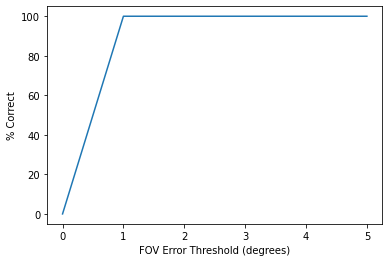

In [15]:
th_0 = 0
th_1 = 0
th_2 = 0
th_3 = 0
th_4 = 0
th_5 = 0

percent_correct = []

k = 86111

for i  in range(np.shape(output)[1]):
    
    predicted_fov = 2*np.arctan(112/(2*output[0][i][0]))
    actual_fov = 2*np.arctan(112/(2*Fx[k]))
    
    if abs(predicted_fov - actual_fov) <= 0:
        
        th_0 += 1 
        
    if abs(predicted_fov - actual_fov) <= 1:
        
        th_1 += 1
        
    if abs(predicted_fov - actual_fov) <= 2:
        
        th_2 += 1
        
    if abs(predicted_fov - actual_fov) <= 3:
        
        th_3 += 1
        
    if abs(predicted_fov - actual_fov) <= 4:
        
        th_4 += 1
        
    if abs(predicted_fov - actual_fov) <= 5:
        
        th_5 += 1
        
    k += 1

percent_correct.append(th_0/np.shape(output)[1]*100)
percent_correct.append(th_1/np.shape(output)[1]*100)
percent_correct.append(th_2/np.shape(output)[1]*100)
percent_correct.append(th_3/np.shape(output)[1]*100)
percent_correct.append(th_4/np.shape(output)[1]*100)
percent_correct.append(th_5/np.shape(output)[1]*100)

plt.plot([0,1,2,3,4,5],percent_correct)
plt.xlabel("FOV Error Threshold (degrees)")
plt.ylabel("% Correct")

In [16]:
th_0, th_1, th_2, th_3, th_4, th_5

(0, 36906, 36906, 36906, 36906, 36906)

In [17]:
th_0/np.shape(output)[1], th_1/np.shape(output)[1], th_2/np.shape(output)[1], th_3/np.shape(output)[1]

(0.0, 1.0, 1.0, 1.0)

In [5]:
error = {}

error["fx"] = 0
error["fy"] = 0
error["u0"] = 0
error["v0"] = 0
error["baseline"] = 0
error["disparity"] = 0
error["x"] = 0
error["y"] = 0
error["z"] = 0
error["pitch"] = 0
error["xworld"] = 0
error["yworld"] = 0
error["zworld"] = 0



key_counter = 0

for i in error.keys():
    
    k = 55524

    for j  in range(np.shape(output)[1]):
        
        if key_counter == 0: 
    
            predicted_fx = output[key_counter][j][0]
            actual_fx = Fx[k]
    
            error[i] += abs(predicted_fx - actual_fx)
        
        if key_counter == 1: 
    
            predicted_fy = output[key_counter][j][0]
            actual_fy = Fy[k]
    
            error[i] += abs(predicted_fy - actual_fy)
        
        if key_counter == 2: 
    
            predicted_u0 = output[key_counter][j][0]
            actual_u0 = U0[k]
    
            error[i] += abs(predicted_u0 - actual_u0)
        
        if key_counter == 3: 
    
            predicted_v0 = output[key_counter][j][0]
            actual_v0 = V0[k]
    
            error[i] += abs(predicted_v0 - actual_v0)
        
        if key_counter == 4: 
    
            predicted_baseline = output[key_counter][j][0]
            actual_baseline = Baseline[k]
    
            error[i] += abs(predicted_baseline - actual_baseline)
        
        if key_counter == 5: 
    
            predicted_disparity = output[key_counter][j][0]
            actual_disparity = Disparity[k]
    
            error[i] += abs(predicted_disparity - actual_disparity)
        
        if key_counter == 6: 
    
            predicted_tx = output[key_counter][j][0]
            actual_tx = Tx[k]
    
            error[i] += abs(predicted_tx - actual_tx)
        
        if key_counter == 7: 
    
            predicted_ty = output[key_counter][j][0]
            actual_ty = Ty[k]
    
            error[i] += abs(predicted_ty - actual_ty)
        
        if key_counter == 8: 
    
            predicted_tz = output[key_counter][j][0]
            actual_tz = Tz[k]
    
            error[i] += abs(predicted_tz - actual_tz)
        
        if key_counter == 9: 
    
            predicted_pitch = output[key_counter][j][0]
            actual_pitch = Pitch[k]
    
            error[i] += abs(predicted_pitch - actual_pitch)
        
        if key_counter == 10: 
    
            predicted_x = output[key_counter][j][0]
            actual_x = X[k]
    
            error[i] += abs(predicted_x - actual_x)
        
        if key_counter == 11: 
    
            predicted_y = output[key_counter][j][0]
            actual_y = Y[k]
    
            error[i] += abs(predicted_y - actual_y)
        
        if key_counter == 12: 
    
            predicted_z = output[key_counter][j][0]
            actual_z = Z[k]
    
            error[i] += abs(predicted_z - actual_z)
        
        k += 1
    
    
    error[i] /= np.shape(output)[1]
    
    key_counter += 1

print (error)

{'fx': 1.286216490572841, 'fy': 1.3617292269398404, 'u0': 0.4937650231999256, 'v0': 0.6355269044602613, 'baseline': 0.13129135592331664, 'disparity': 0.3337598006217669, 'x': 0.15337508699687152, 'y': 0.160628789677968, 'z': 0.16428160049230398, 'pitch': 1.0439506068432465, 'xworld': 1.5492911808480934, 'yworld': 0.8043879380865393, 'zworld': 1.9885211813851058}


# Normalized MAE

In [18]:
error = {}

error["fx"] = 0
error["fy"] = 0
error["u0"] = 0
error["v0"] = 0
error["baseline"] = 0
error["disparity"] = 0
error["x"] = 0
error["y"] = 0
error["z"] = 0
error["pitch"] = 0
error["xworld"] = 0
error["yworld"] = 0
error["zworld"] = 0

mean_fx = 59.32098482132037

mean_fy = 59.32098482132037

mean_u0 = 56.0

mean_v0 = 56.0

mean_baseline = -84.00701782907929

mean_disparity = -10.972388226877689

mean_tx = -84.00701782907929

mean_ty = 0.4372459762640221

mean_tz = -0.5766162683574485

mean_pitch = -12.380371755270145

mean_xw = -91.94288567681566

mean_yw = 0.4372459762640221

mean_zw = 44.48843272766856


key_counter = 0

for i in error.keys():
    
    k = 86111

    for j  in range(np.shape(output)[1]):
        
        if key_counter == 0: 
    
            predicted_fx = output[key_counter][j][0]
            actual_fx = Fx[k]
    
            error[i] += abs(predicted_fx - actual_fx) / mean_fx
        
        if key_counter == 1: 
    
            predicted_fy = output[key_counter][j][0]
            actual_fy = Fy[k]
    
            error[i] += abs(predicted_fy - actual_fy) / mean_fy
        
        if key_counter == 2: 
    
            predicted_u0 = output[key_counter][j][0]
            actual_u0 = U0[k]
    
            error[i] += abs(predicted_u0 - actual_u0) / mean_u0
        
        if key_counter == 3: 
    
            predicted_v0 = output[key_counter][j][0]
            actual_v0 = V0[k]
    
            error[i] += abs(predicted_v0 - actual_v0) / mean_v0
        
        if key_counter == 4: 
    
            predicted_baseline = output[key_counter][j][0]
            actual_baseline = Baseline[k]
    
            error[i] += abs(predicted_baseline - actual_baseline) / mean_baseline
        
        if key_counter == 5: 
    
            predicted_disparity = output[key_counter][j][0]
            actual_disparity = Disparity[k]
    
            error[i] += abs(predicted_disparity - actual_disparity) / mean_disparity
        
        if key_counter == 6: 
    
            predicted_tx = output[key_counter][j][0]
            actual_tx = Tx[k]
    
            error[i] += abs(predicted_tx - actual_tx) / mean_tx
        
        if key_counter == 7: 
    
            predicted_ty = output[key_counter][j][0]
            actual_ty = Ty[k]
    
            error[i] += abs(predicted_ty - actual_ty) / mean_ty
        
        if key_counter == 8: 
    
            predicted_tz = output[key_counter][j][0]
            actual_tz = Tz[k]
    
            error[i] += abs(predicted_tz - actual_tz) / mean_tz
        
        if key_counter == 9: 
    
            predicted_pitch = output[key_counter][j][0]
            actual_pitch = Pitch[k]
    
            error[i] += abs(predicted_pitch - actual_pitch) / mean_pitch
        
        if key_counter == 10: 
    
            predicted_x = output[key_counter][j][0]
            actual_x = X[k]
    
            error[i] += abs(predicted_x - actual_x) / mean_xw
        
        if key_counter == 11: 
    
            predicted_y = output[key_counter][j][0]
            actual_y = Y[k]
    
            error[i] += abs(predicted_y - actual_y) / mean_yw
        
        if key_counter == 12: 
    
            predicted_z = output[key_counter][j][0]
            actual_z = Z[k]
    
            error[i] += abs(predicted_z - actual_z) / mean_zw
        
        k += 1
    
    
    error[i] /= np.shape(output)[1]
    
    key_counter += 1

print (error)

{'fx': 0.015937515621385023, 'fy': 0.015789691998922144, 'u0': 0.015129069450800097, 'v0': 0.013382435791845225, 'baseline': -0.12739093357613276, 'disparity': -0.14603019263958006, 'x': -0.1265458647332407, 'y': 0.29211547592355985, 'z': -0.511076426031596, 'pitch': -0.3085142761565729, 'xworld': -1.3364487794856912, 'yworld': 0.27129192630690024, 'zworld': 4.534190158947845}
